# Imports, Data Reading, Functions

In [6]:
import math
import random
from os import listdir
from itertools import product
from collections import Counter
import dill as pickle

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import pandas as pd
import numpy as np
from tqdm import tqdm

from scipy.stats import ks_2samp, entropy
from sklearn.neighbors import KernelDensity

import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
sns.set(rc={"figure.dpi": 150})


from rdkit import Chem
from rdkit.Chem import AllChem, rdFMCS, rdMolDescriptors, MolFromSmiles, MolToSmiles, Draw, MolFromMolFile
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules

from rdkit.Chem import ChemicalFeatures
from rdkit import Geometry
from rdkit.Chem.rdmolfiles import MolFromPDBBlock, MolFromPDBFile
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.RDPaths import RDDataDir
import os.path

fdefFile = os.path.join(RDDataDir,'BaseFeatures.fdef')
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefFile)

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') # removes annoying RDKit warnings

import py3Dmol
import mols2grid

from rdkit.Chem.SaltRemover import SaltRemover
remover = SaltRemover()

import frag_funcs
import importlib
importlib.reload(frag_funcs)

from ipywidgets import interact

pairs = ['Donor-Aromatic',
        'Aromatic-Acceptor',
        'Aromatic-Aromatic',
        'Donor-Donor',
        'Donor-Acceptor',
        'Acceptor-Acceptor']


### Data Reading

In [2]:
nx = 500
n_bins = 20

data_dir = '/home/wjm41/ml_physics/frag-pcore-screen/data/Mpro'
frags = pickle.load(open(data_dir + '/frags_mpro.pickle', 'rb'))

pickle_dir = '/home/wjm41/ml_physics/frag-pcore-screen/notebooks/pickles'
frag_pair_distance_dict = pickle.load(
    open(pickle_dir + '/frag_pair_distance_dict_mpro.pickle', 'rb'))

kde_dir = '/rds-d7/project/rds-ZNFRY9wKoeE/EnamineREAL/pickles/'
kdes = {'mpro': 'kde_dict_spl_mpro.pickle',
        'mac1': 'kde_dict_spl_mac1.pickle',
        'dpp11': 'kde_dict_spl_dpp11.pickle'}
new_kdes = pickle.load(open(kde_dir+kdes['mpro'], 'rb'))


### Useful Functions

In [9]:
def enrichment(score_df, n=10, score='score', index='hit', log=False, ascending=True):
    df = score_df[score_df[score].notna()].copy() # ignores NaNs
    df.loc[:, score] = df[score].astype(float)
    orig_prop = len(df.loc[df[index]])/len(df)
    if log:
        print('orig proportion of {}: {:.3f}%'.format(index, orig_prop*100))
    
    sorted_df = df.nlargest(n=n, columns=score)

    new_prop = len(sorted_df[sorted_df[index]])/len(sorted_df)
    if log:
        print('N = {}, n_hits = {}, new proportion of {}: {:.3f}%'.format(n, len(sorted_df[sorted_df[index]]),index, new_prop*100))
    EF = new_prop/orig_prop
    return EF


def score_dist(kde, dist):
    if len(dist):  # non-zero length

        # log-prob (larger = higher prob)
        # score using scipy spline!
        score = kde(dist.reshape(-1, 1))

        score = np.mean(score)

        return score
    else:
        return np.nan


# Reading/Generating Conformers and Pharmacophores

In [3]:
# load ligands 
interesting_pcores = ['Donor', 'Acceptor', 'Aromatic']

hits = pickle.load(open(data_dir+'/hits_new.pickle', 'rb'))   
threshold = 5 # IC50 threshold for activity 

hitpcore_df = frag_funcs.return_pcore_dataframe(hits, interesting_pcores, hit=True, threshold=threshold)

smiles_list = [None]*len(set(hitpcore_df['mol_id']))  
activity_list = [None]*len(set(hitpcore_df['mol_id']))
IC50_list = [None]*len(set(hitpcore_df['mol_id']))

for i in tqdm(set(hitpcore_df['mol_id'])):
    smiles_list[i] = hitpcore_df[hitpcore_df['mol_id']==i].iloc[0]['smiles']
    activity_list[i] = hitpcore_df[hitpcore_df['mol_id']==i].iloc[0]['active']
    IC50_list[i] = hitpcore_df[hitpcore_df['mol_id']==i].iloc[0]['IC50']

xray_hit_pairs = pickle.load(open(data_dir+'/hit_pairs.pickle', 'rb'))

xray_df = pd.DataFrame(columns=['smiles', 'hit']+pairs)
xray_df['smiles'] = smiles_list
xray_df['hit'] = activity_list

xray_prop = len(xray_df[xray_df['hit']])/len(xray_df)
print('base rate = {:.1f}%'.format(xray_prop*100))
assert len(hits) == len(xray_hit_pairs)

100%|██████████| 213/213 [00:00<00:00, 232.66it/s]

base rate = 11.7%


In [4]:
df = pd.read_csv('../data/activity_data.csv')
df = df[(df['acrylamide']==False) & (df['chloroacetamide']==False)]
df.reset_index(inplace=True)

all_mols = [None]*len(df)
for i,row in tqdm(df.iterrows(), total=len(df)):
    try:
        mol = MolFromSmiles(row['SMILES'])

        #constrained conformer generation
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)

        mol = Chem.RemoveHs(mol)

        #calculate properties from surviving conformers
        conf = mol.GetConformer()

        mol_data = [mol]
        for j,atom in enumerate(mol.GetAtoms()):
            mol_data.append([atom.GetSymbol(),
                                conf.GetPositions()[j]
                                ])
        # NaNs
        mol_data.append(row['f_avg_IC50'])
        all_mols[i] = mol_data
    except Exception as ex:
        print(ex)
        print(str(i)+' failed')
        continue
all_mols = [mol for mol in all_mols if mol is not None]

threshold = 5 # IC50 threshold for activity 
hitpcore_df = frag_funcs.return_pcore_dataframe(all_mols, interesting_pcores, hit=True, threshold=threshold)

fresh_hit_pairs = [None]*len(set(hitpcore_df['mol_id']))
for j,i in tqdm(enumerate(set(hitpcore_df['mol_id'])), total=len(fresh_hit_pairs)):
    hit_pair_individual = {}
    
    for pcore_pair in product(interesting_pcores,repeat=2):
        core_a,core_b = pcore_pair
        combo = core_a+'-'+core_b
        hit_pair_individual[combo], _ = frag_funcs.get_pair_distances(hitpcore_df[hitpcore_df['mol_id']==i], core_a, core_b, frag=False, active=None)
    fresh_hit_pairs[j] = hit_pair_individual

smiles_list = []
activity_list = []
for i in tqdm(set(hitpcore_df['mol_id'])):
    smiles_list.append(hitpcore_df[hitpcore_df['mol_id']==i].iloc[0]['smiles'])
    activity_list.append(hitpcore_df[hitpcore_df['mol_id']==i].iloc[0]['active'])
    
fresh_df = pd.DataFrame(columns=['smiles', 'hit']+pairs)
fresh_df['smiles'] = smiles_list
fresh_df['hit'] = activity_list

fresh_prop = len(fresh_df[fresh_df['hit']])/len(fresh_df)
print('base rate = {:.1f}%'.format(fresh_prop*100))

100%|██████████| 1360/1360 [00:01<00:00, 802.72it/s]


base rate = 31.1%


In [27]:
n_zinc = 100
n_repeats = 3

def gen_zinc(n=100):
    zinc_smi = pd.read_csv(
        '/rds-d2/user/wjm41/hpc-work/datasets/ZINC/zinc_250k.csv')['smiles'].values

    rand_smi = random.sample(list(zinc_smi), k=n_zinc)

    zinc_mols = [None]*len(rand_smi)
    for i,smi in enumerate(rand_smi):
        try:
            mol = MolFromSmiles(smi)

            #constrained conformer generation
            mol = Chem.AddHs(mol)
            AllChem.EmbedMolecule(mol)

            mol = Chem.RemoveHs(mol)

            #calculate properties from surviving conformers
            conf = mol.GetConformer()

            mol_data = [mol]
            for j,atom in enumerate(mol.GetAtoms()):
                mol_data.append([atom.GetSymbol(),
                                    conf.GetPositions()[j]
                                    ])
            zinc_mols[i] = mol_data
        except:
            continue

    assert len(zinc_mols) == n_zinc

    zinc_mols = [ i for i in zinc_mols if i]
    zinccore_df = frag_funcs.return_pcore_dataframe(zinc_mols, interesting_pcores, hit=False)

    zinc_pairs = [None]*len(set(zinccore_df['mol_id']))
    for j,i in tqdm(enumerate(set(zinccore_df['mol_id'])), total=len(zinc_pairs)):
        zinc_pair_individual = {}
        
        for combo in pairs:
            core_a,core_b = combo.split('-')
            zinc_pair_individual[combo], _ = frag_funcs.get_pair_distances(zinccore_df[zinccore_df['mol_id']==i], core_a, core_b, frag=False, active=None)
        zinc_pairs[j] = zinc_pair_individual

    zinc_smi = []
    zinc_activity = []

    for i in set(zinccore_df['mol_id']):
        zinc_smi.append(zinccore_df[zinccore_df['mol_id']==i].iloc[0]['smiles'])
        zinc_activity.append(False)
        
    assert len(zinc_smi) == len(zinc_pairs)

    zinc_df = pd.DataFrame(columns=['smiles', 'hit']+pairs)
    zinc_df['smiles'] = zinc_smi
    zinc_df['hit'] = zinc_activity
    return zinc_df, zinc_pairs


### Scoring

100%|██████████| 100/100 [00:05<00:00, 19.01it/s]


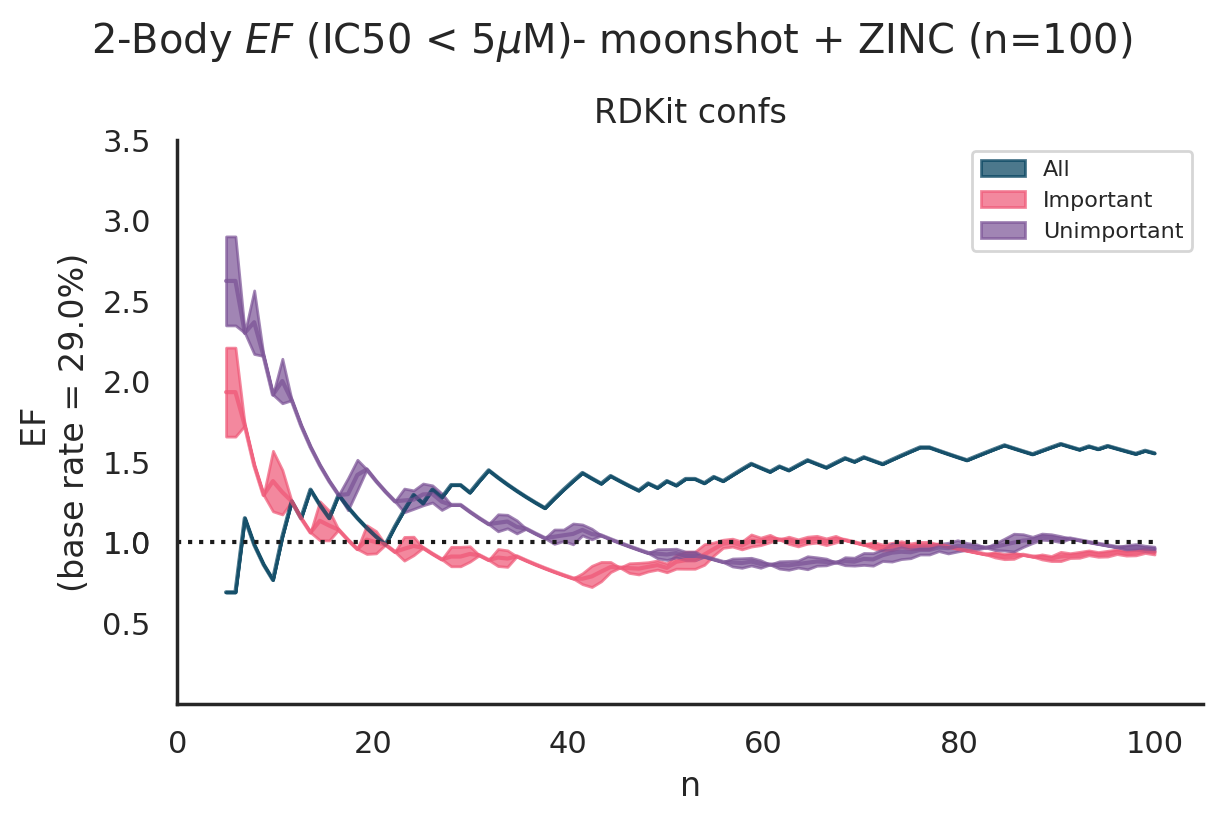

In [28]:
important = ['Donor-Aromatic',
             'Donor-Acceptor',
            'Aromatic-Aromatic']
unimportant = ['Donor-Donor',
               'Aromatic-Acceptor',
               'Acceptor-Acceptor']

kde_dict_opt = new_kdes

pairs = important+unimportant

EFs = []
EFs_imp = []
EFs_nonimp = []

for k in range(5):
    zinc_df, zinc_pairs = gen_zinc(n=100)
    for j,combo in enumerate(pairs):
        core_a,core_b = combo.split('-')
        kde = kde_dict_opt[combo]
        for i in range(len(fresh_hit_pairs)):
            fresh_dist = fresh_hit_pairs[i][combo][0]
            fresh_df.at[i, combo] = score_dist(kde, fresh_dist)

        for i in range(len(zinc_pairs)):
            zinc_dist = zinc_pairs[i][combo][0]
            zinc_df.at[i, combo] = score_dist(kde, zinc_dist)

    # CALCULATE EFs

    fresh_df['df'] = 'Moonshot'
    zinc_df['df'] = 'ZINC'
    total_df = pd.concat([fresh_df, zinc_df]).reset_index()
    total_df[pairs] = total_df[pairs].astype(float)
    total_df['hit'] = total_df['hit'].astype('Int64').astype(bool)

    pairs_and_scores = [(important, 'imp_score'),
                        (unimportant, 'nonimp_score'),
                        (pairs, 'both_score')]

    for pair, score in pairs_and_scores:
        x = total_df[pair].to_numpy()
        x[np.all(np.isnan(x), axis=1)] = -100
        total_df[score] = np.nanmean(x, axis=1)
        # total_df[score] = np.nanmin(x, axis=1)

    # total_df['both_score'] = np.nanmin(x, axis=1)
    # total_df['both_score'] = np.ma.sum(total_df[pairs].to_numpy(na_value=False), axis=1)
    # scores = total_df[pairs].to_numpy().astype(float)
    # total_df['weighed_score'] = np.where(np.isnan(x), 0, x).dot(num_weights)/np.where(np.isnan(x), 0, 1).dot(num_weights)
    # print(total_df.head())

    # n_list = np.logspace(start=np.log10(5), stop=2, num=20) # only check top 100
    n_list = np.linspace(start=5, stop=100, num=100)

    fresh_EF = [enrichment(total_df, n=int(n), score='both_score') for n in n_list]
    fresh_EF_imp = [enrichment(total_df, n=int(n), score='imp_score') for n in n_list]
    fresh_EF_nonimp = [enrichment(total_df, n=int(n), score='nonimp_score') for n in n_list]
    # fresh_EF_weighed = [enrichment(total_df, n=int(n),  score='weighed_score') for n in n_list]
    
    EFs.append(fresh_EF)
    EFs_imp.append(fresh_EF_imp)
    EFs_nonimp.append(fresh_EF_nonimp)
orig_prop = len(total_df[total_df['hit']])/len(total_df)

# PLOTTING
sns.set_style('white')
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True,
                       sharey=True, dpi=200, constrained_layout=True)
y_means = [np.mean(EFs, axis=0), np.mean(
    EFs_imp, axis=0), np.mean(EFs_nonimp, axis=0)]
yerrs = [np.std(EFs, axis=0), np.std(EFs_imp, axis=0),
         np.std(EFs_nonimp, axis=0)]

# ax.errorbar(n_list, np.mean(EFs_imp, axis=0), yerr=yerrs[0],
#             fmt='-', label='Important', color='#7a5195', alpha=0.7)
# ax.errorbar(n_list, np.mean(EFs_nonimp, axis=0), yerr=yerrs[1],
#             fmt='-', label='Unimportant', color='#ef5675', alpha=0.7)
# ax.errorbar(n_list, np.mean(EFs, axis=0), yerr=yerrs[2], fmt='-',
#             label='All', color='#003f5c', alpha=0.7)

ax.plot(n_list, y_means[0],
        '-', color='#003f5c', alpha=0.7)
ax.plot(n_list, y_means[1],
        '-', color='#ef5675', alpha=0.7)
ax.plot(n_list, y_means[2], '-',
        color='#7a5195', alpha=0.7)
ax.fill_between(n_list, y_means[0]-yerrs[0], y_means[0]+yerrs[0],
                label='All', color='#003f5c', alpha=0.7)
ax.fill_between(n_list, y_means[1]-yerrs[1], y_means[1]+yerrs[1],
                label='Important', color='#ef5675', alpha=0.7)
ax.fill_between(n_list, y_means[2]-yerrs[2], y_means[2]+yerrs[2],
                label='Unimportant', color='#7a5195', alpha=0.7)

fig.suptitle(
    r'2-Body $EF$ (IC50 < {}$\mu$M)- moonshot + ZINC (n={})'.format(threshold, n_zinc))
ax.set_title('RDKit confs')
plt.legend(prop={'size': 8})
ax.plot([0, 100], [1, 1], 'k:')

extraticks = [1]
ax.set_yticks(list(plt.yticks()[0]) + extraticks)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set_xlabel('n')
ax.set_ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))
sns.despine()
plt.show()


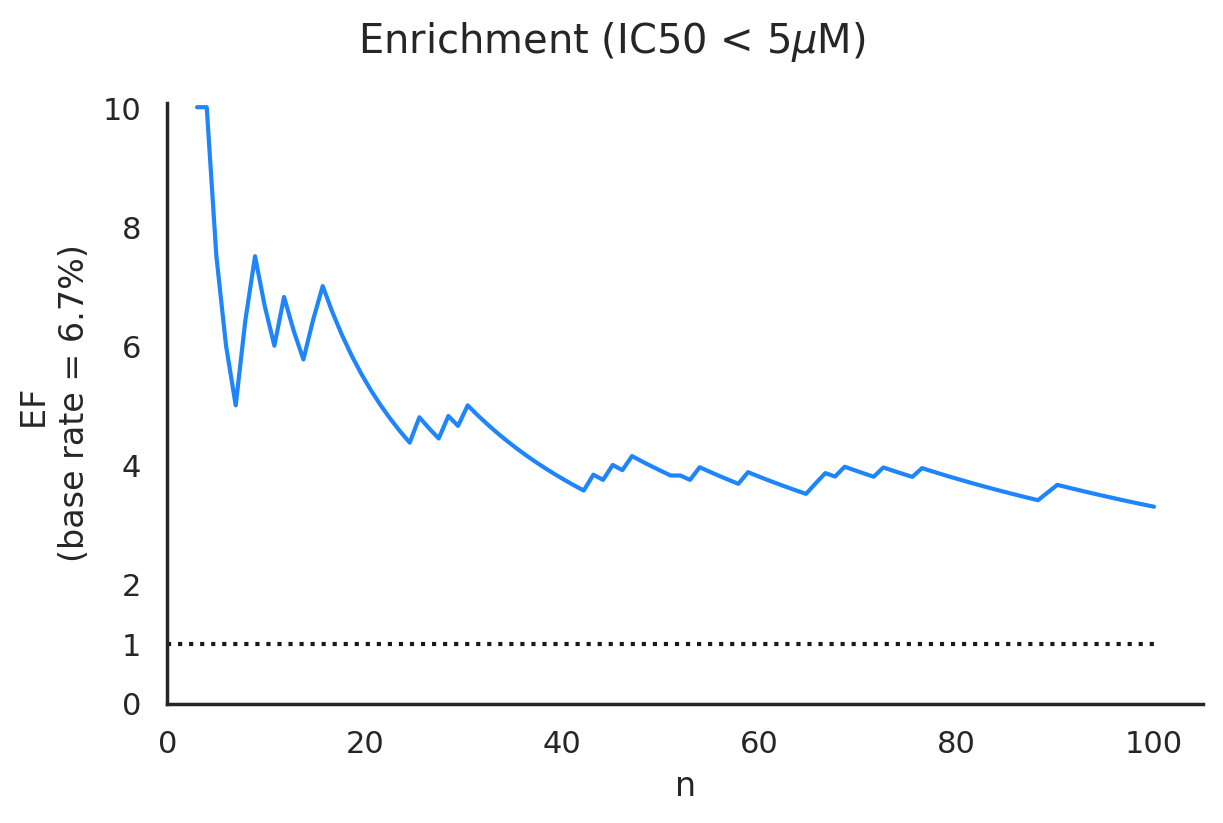

In [54]:
sns.set(font='Free Mono')
sns.set_style('white')
orig_prop = len(total_df[total_df['hit']])/len(total_df)

# PLOTTING
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, dpi=200, constrained_layout=True)
fig.suptitle(r'Enrichment (IC50 < {}$\mu$M)'.format(threshold))
# plt.xscale('log')
# plt.legend(prop={'size': 8})

n_list = np.linspace(start=3, stop=100, num=100)  # only check top 100
fresh_EF = [enrichment(total_df, n=int(n), score='both_score') for n in n_list]
ax.plot(n_list, fresh_EF, '-', color='#1E85FC')
ax.plot([0, 100], [1, 1], 'k:')

extraticks = [1]
ax.set_yticks(list(plt.yticks()[0]) + extraticks)
ax.set_ylim(bottom=0, top=10.1)
ax.set_xlim(left=0)
ax.set_xlabel('n')
ax.set_ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))
sns.despine()
plt.show()


In [ ]:
# weigh & score pharmacophores

important = ['Donor-Aromatic',
             'Donor-Acceptor',
            'Aromatic-Aromatic']
unimportant = ['Donor-Donor',
               'Aromatic-Acceptor',
               'Acceptor-Acceptor']

kde_dict_opt = new_kdes

pairs = important+unimportant

for j,combo in enumerate(pairs):
    core_a,core_b = combo.split('-')
    kde = kde_dict_opt[combo]

    for i in range(len(xray_hit_pairs)):
        dist = xray_hit_pairs[i][combo][0]
        
        xray_df.at[i, combo] = score_dist(kde, dist)
            
    for i in range(len(fresh_hit_pairs)):
        fresh_dist = fresh_hit_pairs[i][combo][0]
        
        fresh_df.at[i, combo] = score_dist(kde, fresh_dist)
    print('Xray: Prop of NaNs for {} = {:.1f}%'.format(combo, 100*len(xray_df[xray_df[combo].isnull()])/len(xray_df)))
    print('Fresh: Prop of NaNs for {} = {:.1f}%'.format(
        combo, 100*len(fresh_df[fresh_df[combo].isnull()])/len(fresh_df)))

# CALCULATE EFs

hit_dfs = [xray_df, fresh_df]
for hit_df in hit_dfs:
    hit_df[pairs] = hit_df[pairs].astype(float)

    hit_df['imp_score'] = np.nanmean(hit_df[important].to_numpy(), axis=1)
    hit_df['nonimp_score'] = np.nanmean(hit_df[unimportant].to_numpy(), axis=1)
    hit_df['hit'] = hit_df['hit'].astype('Int64').astype(bool)

    x = hit_df[pairs].to_numpy()
    hit_df['both_score'] = np.nanmean(x, axis=1)


n_list = np.logspace(start=1, stop=2, num=20) # only check from 10 to 100

xray_EF = [enrichment(xray_df, n=int(n), score='both_score') for n in n_list]
xray_EF_imp = [enrichment(xray_df, n=int(n), score='imp_score') for n in n_list]
xray_EF_nonimp = [enrichment(xray_df, n=int(n), score='nonimp_score') for n in n_list]

fresh_EF = [enrichment(fresh_df, n=int(n), score='both_score') for n in n_list]
fresh_EF_imp = [enrichment(fresh_df, n=int(n), score='imp_score') for n in n_list]
fresh_EF_nonimp = [enrichment(fresh_df, n=int(n), score='nonimp_score') for n in n_list]

xray_prop = len(xray_df[xray_df['hit']])/len(xray_df)
fresh_prop = len(fresh_df[fresh_df['hit']])/len(fresh_df)

# PLOTTING

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, dpi=150, constrained_layout=True)
axs[0].plot(n_list, xray_EF_imp, '-', label='Important',
            color='#7a5195', alpha=0.7)
axs[0].plot(n_list, xray_EF_nonimp, '-', label='Unimportant', color='#ef5675', alpha=0.7) 
axs[0].plot(n_list, xray_EF, '-', label='All', color='#003f5c', alpha=0.7)

axs[1].plot(n_list, fresh_EF_imp, '-', label='Important', color='#7a5195', alpha=0.7)
axs[1].plot(n_list, fresh_EF_nonimp, '-', label='Unimportant', color='#ef5675', alpha=0.7) 
axs[1].plot(n_list, fresh_EF, '-', label='All', color='#003f5c', alpha=0.7)

fig.suptitle(r'2-Body $EF(n)$ (IC50 < {}$\mu$M) - moonshot molecules only'.format(threshold))
axs[0].set_title('X-ray confs (n={})'.format(len(xray_df)))
axs[1].set_title('RDKit confs (n={})'.format(len(fresh_df)))
plt.legend(prop={'size': 8})

for ax in axs:
    ax.plot(n_list, np.ones_like(n_list), 'k:')

    # extraticks = [1]
    # ax.set_yticks(list(plt.yticks()[0]) + extraticks)
    # ax.set_ylim(bottom=0)
    ax.set_xlabel('n')
axs[0].set_ylabel('EF \n(base rate = {:.1f}%)'.format(xray_prop*100))
axs[1].set_ylabel('EF \n(base rate = {:.1f}%)'.format(fresh_prop*100))
plt.show()
